In [7]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
dataset = datasets.fetch_california_housing(as_frame = True)
# print(dataset.DESCR)

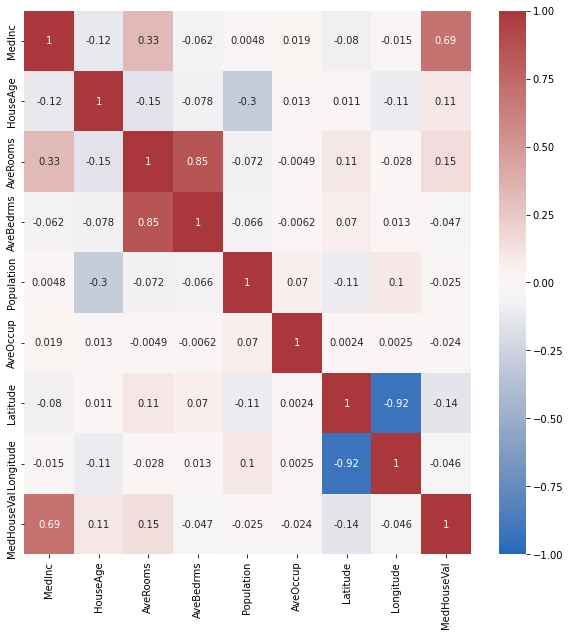

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 10))
cor_matrix = sns.heatmap(dataset.frame.corr(), vmin=-1, vmax=1, annot=True, cmap = "vlag")

In [9]:
subset = dataset.frame.drop(["Longitude", "Latitude"], axis=1)
variables = subset.columns
n_variables = len(variables)
print(variables, n_variables)

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'MedHouseVal'],
      dtype='object') 7


In [10]:
# # fig settings
# fig, axs = plt.subplots(n_variables - 1, 2, constrained_layout=True, figsize=(10, 10))

# # plot figs
# for i in range(0,n_variables - 1):
#   # sns.scatterplot(data = subset, x = variables[i], y = variables[-1], marker="+", ax = axs[i,0])
#   sns.histplot(data = subset, x = variables[i], ax = axs[i,1], stat = "density", kde = True)


In [11]:
# sns.scatterplot(data=dataset.frame, x="Longitude", y="Latitude", size="MedHouseVal", hue="MedHouseVal", palette = "vlag")
# sns.barplot(data =dataset.frame, x='AveRooms', y='MedHouseVal')

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np

dataset.frame_normalized = StandardScaler().fit_transform(dataset.frame)
# We drop Longitude as well since Latitude has enough information?
X = dataset.frame_normalized[:,0:len(dataset.frame.columns) - 2]
y = dataset.frame_normalized[:,len(dataset.frame.columns) - 1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 9)
X_train = np.insert(X_train, 0, np.ones(X_train.shape[0]), axis=1)
X_test = np.insert(X_test, 0, np.ones(X_test.shape[0]), axis=1)



In [13]:
# np.savetxt('X_train.txt', X_train)
# np.savetxt('X_test.txt', X_test)
# np.savetxt('y_train.txt', y_train)
# np.savetxt('y_test.txt', y_test)

<BarContainer object of 7 artists>

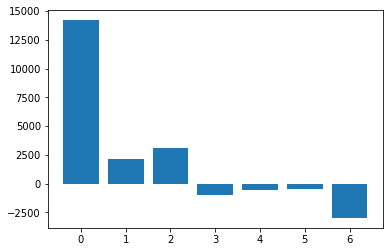

In [14]:
u = X.transpose().dot(y)
plt.clf
plt.bar(np.arange(X.shape[1]),u.flatten())

Minimise $$ F(\theta) = \frac{1}{n}||Y-X\theta||_{2}^{2} + \lambda||\theta||_{2}^{2} = \frac{1}{n}\sum_{1}^{n} MSE_{i} + \lambda\sum{\theta_{i}^2}$$
which has gradient
$$ \nabla{F} = \frac{1}{n}X^{T}(Y-X\theta) + \lambda\theta

In [15]:
gradient_ridge = lambda X, err, theta, lmbda: (1/X.shape[0]) * np.dot(X.T, err) + 1*lmbda*theta
loss = lambda X, y, theta: np.mean((np.dot(X,theta)-y)**2)

def GD_ridge(X, y, niter, step=0.001, pen=0):
    theta = np.zeros(X.shape[1])
    loss_evol = np.zeros(niter)
    for i in range(niter):
        error_k = np.dot(X, theta) - y
        theta = theta - step*gradient_ridge(X, error_k, theta, pen)
        loss_evol[i] = loss(X, y, theta)
    return theta, loss_evol


Q2. Gradient descent with small ridge penalty and varying fixed step sizes

In [43]:
niter = 300
steps = [1/10**i for i in range(5)]
penalty = 0.0001
loss_evol = np.zeros((niter, len(steps)))
theta = np.zeros((len(steps), X_train.shape[1]))

for i in range(len(steps)):
    s = steps[i]
    th, loss_evol[:, i] = GD_ridge(X_train, y_train, niter, step=s, pen=penalty)
    theta[i] = th[-1]

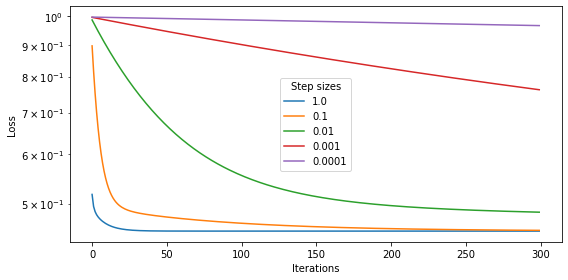

In [44]:
loss_evol = pd.DataFrame(loss_evol, columns=steps)

plt.clf
plt.figure(figsize=(8,4), tight_layout=True)
plt.plot(loss_evol, label=steps)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.yscale('log')
plt.legend(title='Step sizes');

For training set

In [1]:
th = theta[2]
plt.clf
plt.figure(figsize = (12,9), tight_layout=True)
plt.subplot(2, 1, 1)
plt.plot( X_train.dot(th)[0:300], 'b.-', label= '$X_1 w$ (prediction)')
plt.plot( y_train[0:300], 'y.-', label='$y_1$ (true)' )
plt.legend()
rel_err = np.linalg.norm(X_train.dot(th) - y_train, 2) / np.linalg.norm(y_train, 2)
plt.title(f'Relative Error = {np.round(rel_err, 4)}')

plt.subplot(2, 1, 2)
plt.plot( X_test.dot(th)[0:300], 'b.-', label='$X_1 w$ (prediction)' )
plt.plot( y_test[0:300], 'y.-', label='$y_1$ (true)' )
plt.legend()
rel_err = np.linalg.norm(X_test.dot(th) - y_test, 2) / np.linalg.norm(y_test, 2)
plt.title(f'Relative Error = {np.round(rel_err, 4)}');

NameError: name 'theta' is not defined

Question 3: What is optimal step choice?

In [87]:
tau = 2/np.linalg.norm(X_train,2)


*Discuss*

Q4. Regression performance on test set for differing ridge penalties

In [89]:
###########
niter = 1000
penalties = np.linspace(start=0.00, stop=0.1, num=20)
step = 0.01

loss_evolution = np.zeros(len(penalties))
theta = np.zeros((X_train.shape[1], len(penalties)))
train_loss = np.zeros(len(penalties))
test_loss = np.zeros(len(penalties))

for i in range(len(penalties)):
    p = penalties[i]
    theta[:, i], loss_evolution = GD_ridge(X_train, y_train, niter, step, pen=p)
    train_loss[i] = loss_evolution[-1]
    test_loss[i] = loss(X_test, y_test, theta[:, i])

explanatory = dataset.frame.columns[:-2]
explanatory = list(np.insert(explanatory, 0, "Intercept"))
theta = pd.DataFrame(theta.T, columns=explanatory)


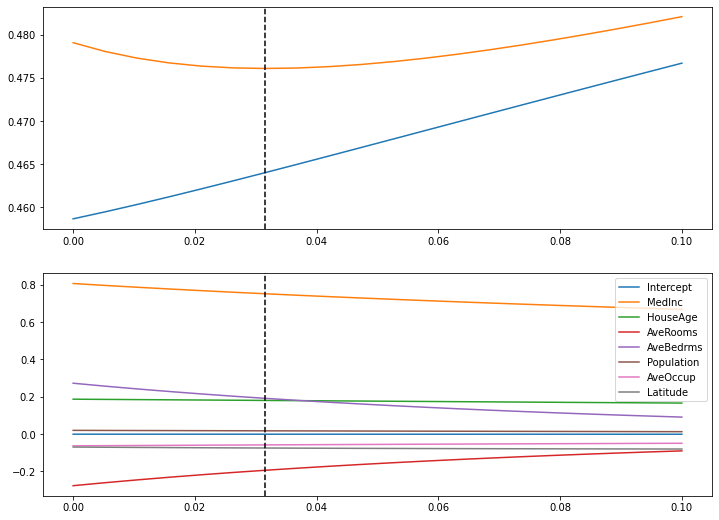

In [90]:
min_i = test_loss.argmin()

plt.subplot(2,1,1)
plt.plot(penalties, train_loss)
plt.plot(penalties, test_loss)
plt.axvline(x=penalties[min_i], linestyle='dashed', c='k')

plt.subplot(2,1,2)
plt.plot(penalties, theta, label=explanatory)
plt.legend(loc='upper right')
plt.axvline(x=penalties[min_i], linestyle='dashed', c='k')

And the coefficients associated are

In [91]:
theta.loc[min_i]

Intercept    -0.000491
MedInc        0.751929
HouseAge      0.180476
AveRooms     -0.193652
AveBedrms     0.191653
Population    0.017693
AveOccup     -0.057746
Latitude     -0.074472
Name: 6, dtype: float64